# Résolutions numériques de l'équation de la chaleur

Nous allons comparer deux méthodes de résolutions numériques du problème suivant:

$$
\begin{equation}
  \left\{
      \begin{aligned}
        u_t(x,t) &= u_{xx}(x, t)\\
        u(x,0) &= u_0(x)\\
        u_x(0,t) &= u_x(1,t) = 0\\
      \end{aligned}
    \right.
\end{equation}
$$

Nous considérons la condition initiale suivante:

$$
\begin{equation}
  u_0(x) = 
  \left\{
      \begin{aligned}
        1 &\text{ si } x \in [\frac{3}{8}, \frac{5}{8}],\\
        0 &\text{ sinon. }\\
      \end{aligned}
    \right.
\end{equation}
$$

## 1) Première solution analytique

Montrons que $$ u(x,t) = \sum_{j = 0}^{+\infty}c_jexp(-j^2\pi^2t)cos(j\pi x) $$ est solution du problème.

### a) Calcul des coefficients


### b) Troncage de la formule

On considère la formule tronquée $$ u_J(x,t) = \sum_{j = 0}^{J}c_jexp(-j^2\pi^2t)cos(j\pi x) $$
Pour $J \in \{10, 100, 1000\}$, nous tracerons la solution approchée aux instants $t = 10^{-6}$, $t = 10^{-4}$, $t = 10^{-2}$ et $t = 1$.



In [102]:
import numpy as np
import numpy.linalg as npl

import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt 
import math

In [71]:
# Paramètres
nbValX = 400
valJ = [10 ** k for k in range(2, 5)]
valT = [10 ** k for k in range(-6, 1, 2)]


# Calcul des J premiers coefficients cj
# OUT: <nd.array> contenant les coefficients cj
def set_Cj(J):
    Cj = np.zeros(J)
    Cj[0] = 1 / 4
    for j in range(1, J):
        Cj[j] = 2 * (math.sin(5 * j * math.pi / 8) - math.sin(3 * j * math.pi / 8)) / (j * math.pi)
    return Cj

# Calcul de uj(x, t)
# Prend Cj en argument pour ne le calculer qu'une seule fois
# OUT: <int> Résultat de la formule tronquée en (x,t)
def Uj(x, t, Cj):
    uj = 0
    for j, cj in enumerate(Cj):
        uj += cj * math.exp(- j**2 * math.pi ** 2 * t) * math.cos(j * math.pi * x)

    return uj

# Construction des vecteurs à afficher
# OUT: <nd.array>, <nd.array> de longueur nbValX, 
#                               le premier étant le maillage de l'intervalle [0, 1]
#                               le second étant les images calculées par la fonction Uj
def set_Uj(J, t):
    x = np.linspace(0, 1, nbValX)
    
    Cj = set_Cj(J)
    y = np.zeros(nbValX)
    for i in range(nbValX):
        y[i] = Uj(x[i], t, Cj)
    
    return x, y

# Affichage des courbes aux instants t dans valT
def show_Uj(J):
    fig, ax = plt.subplots(1, len(valT),figsize=(20,5)) # figures côte à côte (1 ligne et 2 colonnes)

    for i, t in enumerate(valT):
        x, y = set_Uj(J, t)
        ax[i].set_ylim((min(y) - 0.3, max(y) + 0.3))
        ax[i].plot(x, y)

### c) Tracés des courbes

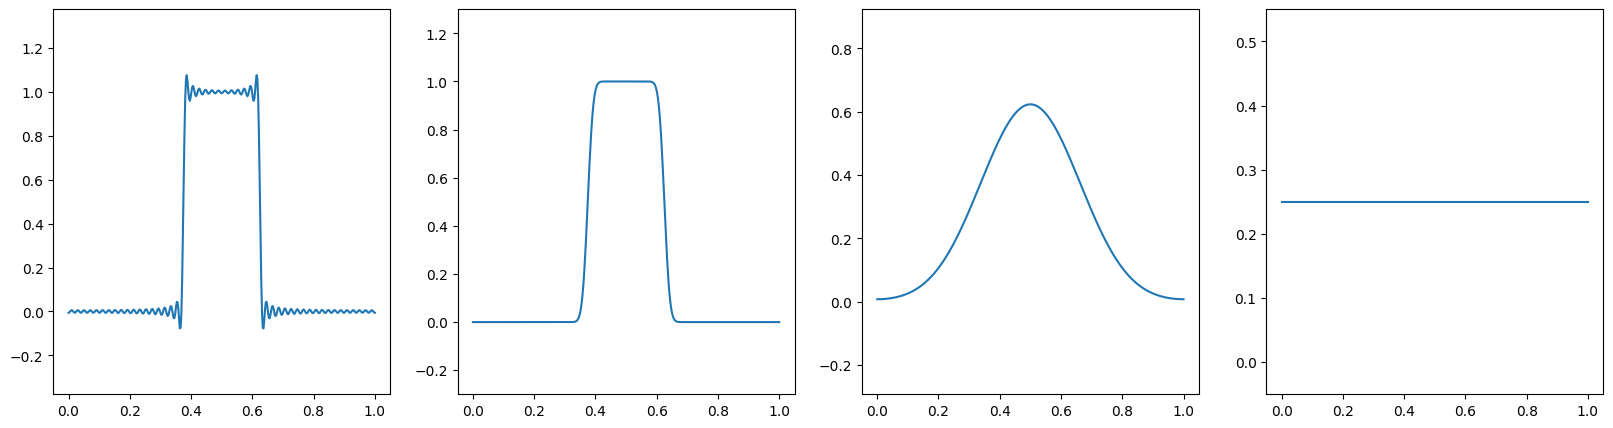

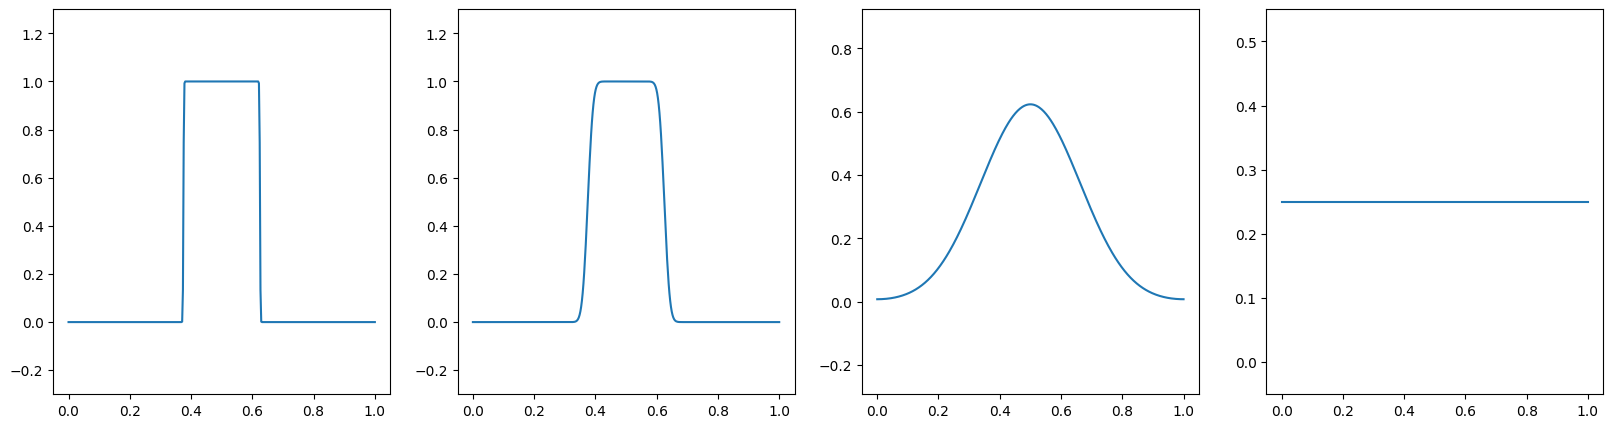

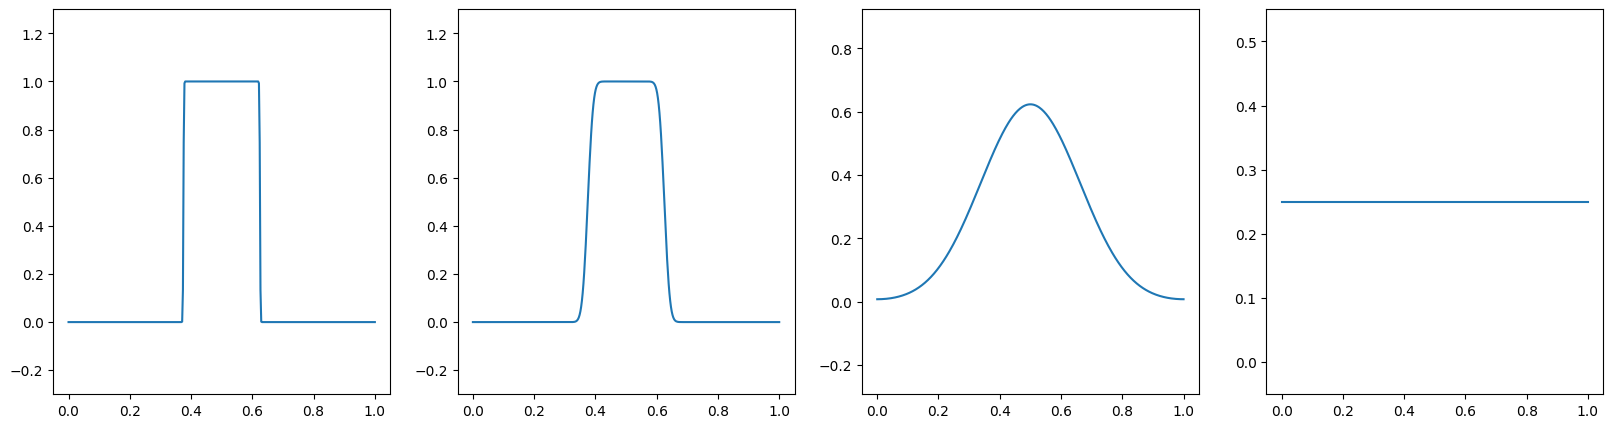

In [72]:
for J in valJ:
    show_Uj(J)

## 2) Schéma explicites aux différences finies

Nous créerons d'abord un maillage $x_0, ..., x_N$ de l'intervalle [0, 1] avec $x_0 = 0$ et $x_N = 1$, et un pas de temps $\Delta x = x_{n+1} - x_n$,\
puis un maillage temporel $t_0, ..., t_M$ avec $t_0 = 0$ et $t_M = T \in \mathbf{R}^+$,  un pas de temps $\Delta t = t^{n+1} - t^n$.

Le schéma explicite s'écrit ainsi $$U^{n+1} = (I_n + \frac{\Delta t}{\Delta x^2}A)U^n,$$ avec 
$$
U^n = \left(
        \begin{array}{ccc} 
            u_0 ^n \\ 
            \vdots \\ 
            u_{N}^n 
        \end{array} 
      \right) 
\quad \text{ et } \quad
A = \left( 
        \begin{array}{ccc} -1 & 1 & & & \\
                            1 & -2 & 1 & & \\
                            & \ddots & \ddots & \ddots & \\
                            & & 1 & -2 & 1 \\
                            & & & 1 & -1 
        \end{array} 
    \right)
$$

### a) Implémentation

In [110]:
# Paramètres

N = 100 # Nombre de sous-intervalles spatiaux
M = 2 * 10 ** 5 # Nombre de sous-intervalles temporels
T = 1 # Borne supérieure de l'intervalle temporel [0, T]

dimX = N + 1 # Nombre de points spatiaux
dimT = M + 1 # Nombre de points temporels
deltaX = 1 / N # Pas spatial
deltaT = T / M # Pas temporel

# Implémentation de A
A = -2 * sps.eye(dimX, format = 'csc') + sps.eye(dimX, k = 1, format = 'csc') + sps.eye(dimX, k = -1, format = 'csc')
A[0, 0] = -1
A[N, N] = -1

# Implémentation de u0
u0 = np.zeros(dimX)
for n in range(int(dimX * 3 / 8), int(dimX * 5 / 8) + 1):
    u0[n] = 1

# Implémentation de la fonction d'itération de Un
def iterUn(k):
    Un1 = u0
    passMatr = sps.identity(dimX, format = 'csc') + A * deltaT / deltaX ** 2
    for i in range(int(k)):
        Un1 = passMatr.dot(Un1)

    return Un1

# Affichage des courbes aux instants t dans valT
def show_expl():
    fig, ax = plt.subplots(1, len(valT),figsize=(20,5))
    x = np.linspace(0, 1, dimX)

    for i, t in enumerate(valT):
        ax[i].set_ylim((-0.2, 1.2))
        ax[i].plot(x, iterUn(t / deltaT))


### b) Tracés de la courbe

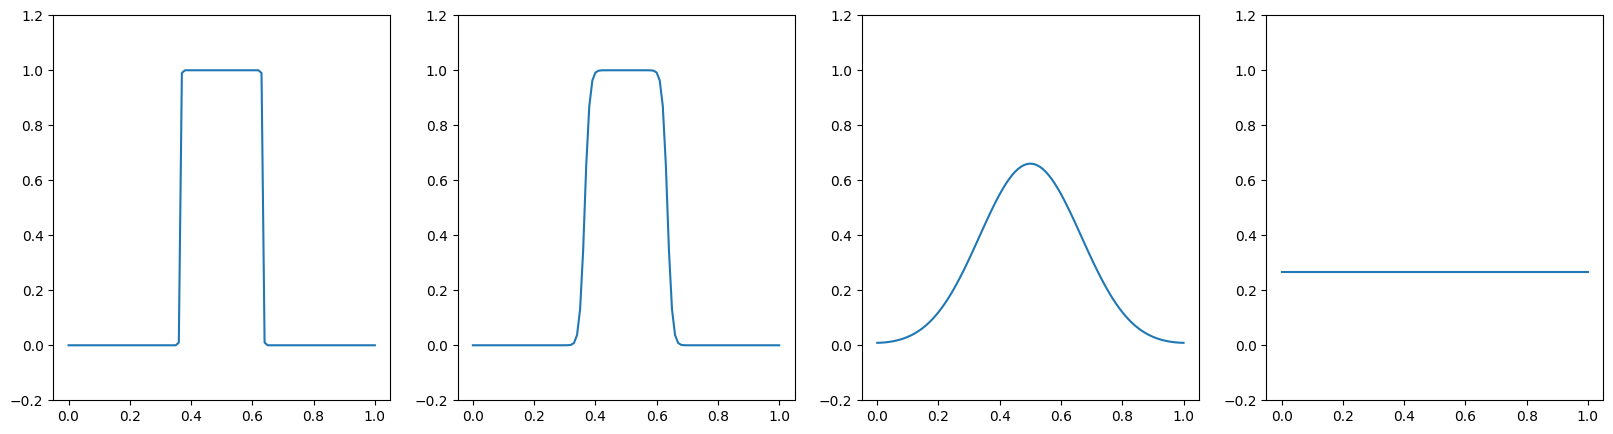

In [75]:
show_expl()

## 3) Schéma implicite aux différences finies

Le schéma implicite aux différences finies s'écrit
$$ U_i ^n = (I_n - \frac{\Delta t}{\Delta x^2}A)U^{n+1}_i$$
On note $P = I_n - \frac{\Delta t}{\Delta x^2}A$ et on obtient ainsi la formule suivante:
$$ PU^{n+1}_i = U^{n}_i$$

Afin de résoudre ce problème, nous disposons de deux solutions:
- Calculer l'inverse de P avec la fonction ```spsl.inv``` puis calculer le produit $ P^{-1}U^{n}_i = U^{n+1}_i$;
- Faire appelle à la fonction ```spsl.spsolve```.

### a) Implémentation

In [111]:
P = sps.identity(dimX, format = 'csc') - A * deltaT / deltaX ** 2
PInv = spsl.inv(P)

# Implémentation de la fonction d'itération de Un avec spsl.inv
def iterUnInv(k):
    Un1 = u0
    for i in range(int(k)):
        Un1 = PInv.dot(Un1)

    return Un1

# Implémentation de la fonction d'itération de Un avec spsl.spsolve
def iterUnSolve(k):
    Un1 = u0
    for i in range(int(k)):
        Un1 = spsl.spsolve(P, Un1)

    return Un1

# Affichage des courbes aux instants t dans valT
def show_impl():
    fig, ax = plt.subplots(1, len(valT),figsize=(20,5))
    x = np.linspace(0, 1, dimX)

    for i, t in enumerate(valT):
        ax[i].set_ylim((-0.2, 1.2))
        ax[i].plot(x, iterUnInv(t / deltaT))

def show_implSolve():
    fig, ax = plt.subplots(1, len(valT),figsize=(20,5))
    x = np.linspace(0, 1, dimX)

    for i, t in enumerate(valT):
        ax[i].set_ylim((-0.2, 1.2))
        ax[i].plot(x, iterUnSolve(t / deltaT))


### b) Tracés de la courbe

Pour $N = 100$, $M = 2 \cdot 10^5$ et $T = 1$, les temps d'exécution sont de 2,6s et 5,3s. \
Pour $N = 100$, $M = 2 \cdot 10^6$ et $T = 1$, les temps d'exécution sont de 6,0s et 28,5s.

Nous privigeons donc la solution avec ```spsl.inv```.

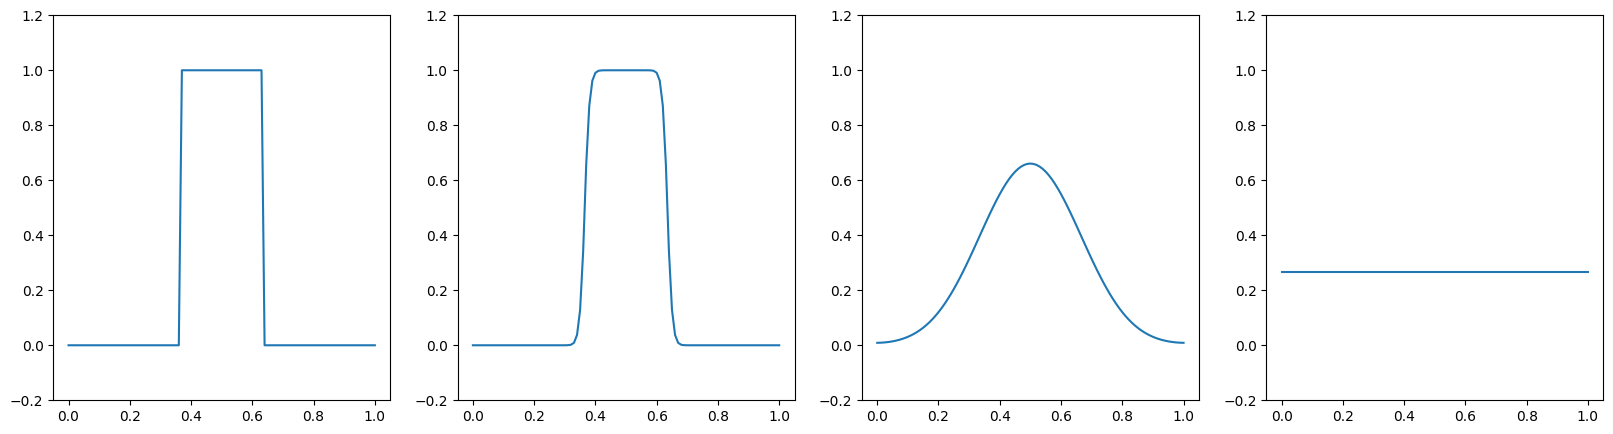

In [112]:
show_impl()

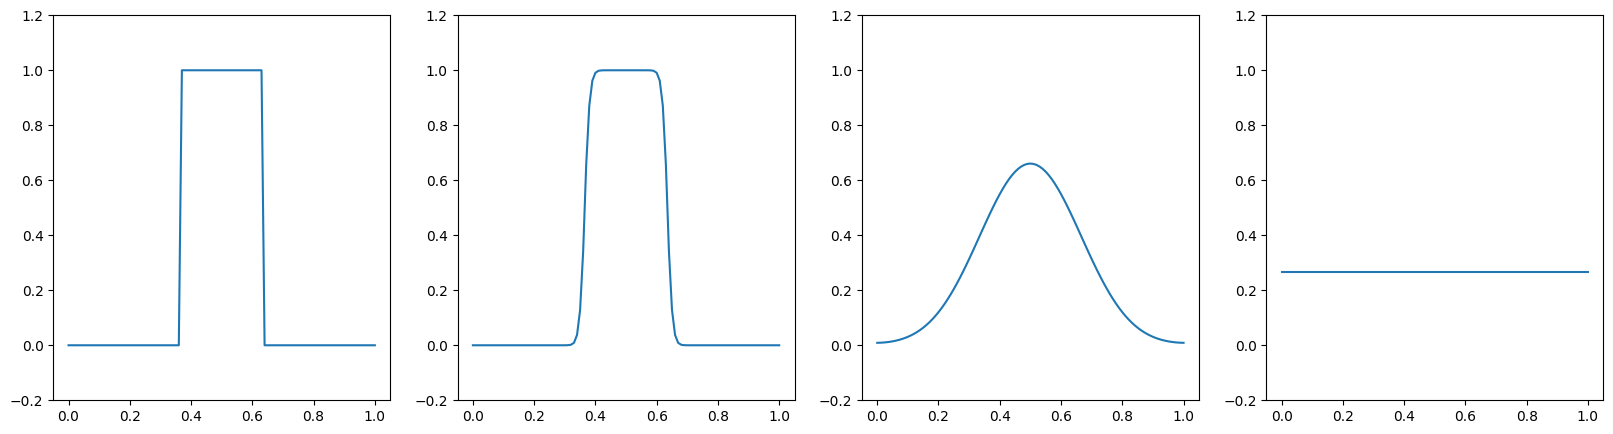

In [113]:
show_implSolve()

## 3) Théta-schéma

Afin de faire un compromis entre les schémas explicites et implicites, nous pouvons utiliser le théta-schéma qui s'écrit pour $\theta \in [0, 1]$
$$ M_{imp} U^{n+1} = M_{exp} U^n $$ 
avec
$$ M_{imp} = I_n - \theta \frac{\Delta t}{\Delta x^2}A \quad \text{et} \quad M_{exp} = I_n + (1 - \theta) \frac{\Delta t}{\Delta x^2}A $$

Remarque: Il s'agit d'un généralisation des deux schémas. En effet, pour $\theta = 0$, nous retrouvons le schéma explicite et pour $\theta = 1$ il s'agit du schéma implicite.

### a) Implémentation

In [120]:
# Calcul de uN+1 à partir de uN
def iterUnTheta(k, theta = 0.2):
    Un = u0
        # Implémentation de Mimp et Mexp
    Mimp = sps.identity(dimX, format = 'csc') - theta * A * deltaT / deltaX ** 2
    MimpInv = spsl.inv(Mimp)
    Mexp = sps.identity(dimX, format = 'csc') + (1 - theta) * A * deltaT / deltaX ** 2
        # Calcul de Un
    for i in range(int(k)):
        Un = MimpInv.dot(Mexp.dot(Un))
    
    return Un


def show_theta():
    fig, ax = plt.subplots(1, len(valT),figsize=(20,5)) # figures côte à côte (1 ligne et 2 colonnes)
    x = np.linspace(0, 1, dimX)

    for i, t in enumerate(valT):
        ax[i].set_ylim((-0.2, 1.2))
        ax[i].plot(x, iterUnTheta(t / deltaT))


### Tracés de la courbe

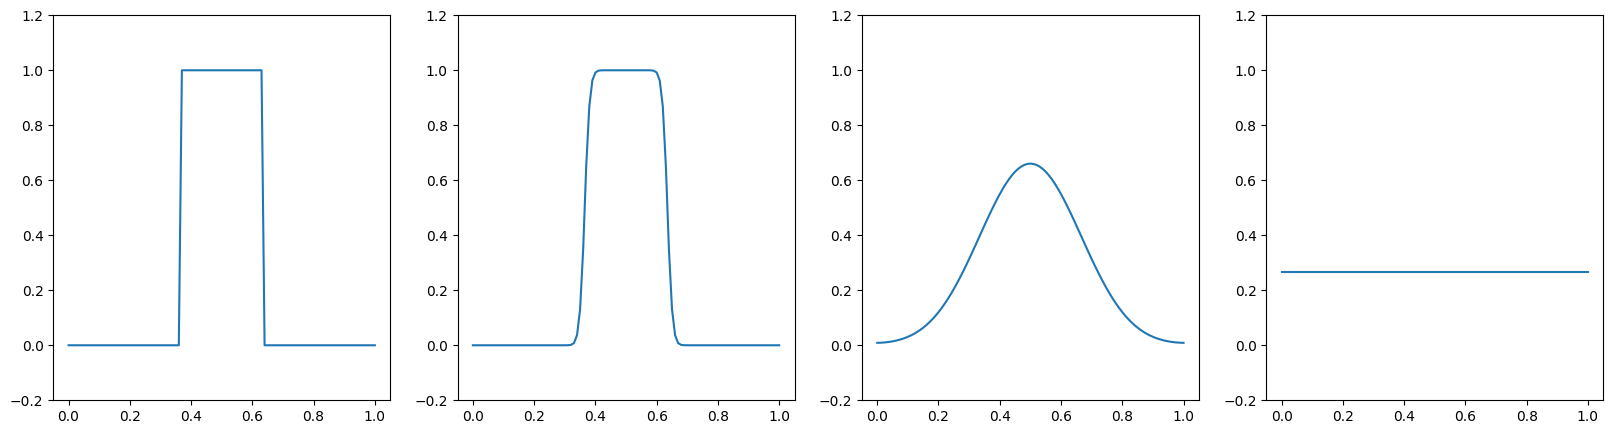

In [121]:
show_theta()

## 4) Comparaison

### a) Implémentation d'une classe approximation
Nous allons commencer par implémenter une classe contenant tous les paramètres ainsi que les méthodes permettant de mettre en oeuvre toutes les solutions abordées jusqu'ici.


In [168]:
class Comparateur():

    def __init__(self):
            # Paramètres
        self.__J = 1000
        self.__N = 100 # Nombre de sous-intervalles spatiaux
        self.__M = 2 * 10 ** 5 # Nombre de sous-intervalles temporels
        self.__T = 1 # Borne supérieure de l'intervalle temporel [0, T]

        self.__dimX = None # Nombre de points spatiaux
        self.__deltaX = None # Pas spatial
        self.__deltaT = None # Pas temporel

            # Matrices
        self.__A = None
        
            # Vecteurs
        self.__u0 = None
        self.__x = None
        self.__y = None
        self.__Cj = None

        self.__start()

    def __start(self):
        self.__dimX = N + 1
        self.__deltaX = 1 / self.__N
        self.__deltaT = self.__T / self.__M

        self.__A = -2 * sps.eye(self.__dimX, format = 'csc') + sps.eye(self.__dimX, k = 1, format = 'csc') + sps.eye(self.__dimX, k = -1, format = 'csc')
        self.__A[0, 0] = -1
        self.__A[self.__N, self.__N] = -1

        self.__u0 = np.zeros(self.__dimX)
        for n in range(int(self.__dimX * 3 / 8), int(self.__dimX * 5 / 8) + 1):
            self.__u0[n] = 1

        self.__x = np.linspace(0, 1, self.__dimX)
        self.__set_Cj()


    # Calcul des J premiers coefficients cj
    # OUT: <nd.array> contenant les coefficients cj
    def __set_Cj(self):
        Cj = np.zeros(self.__J)
        Cj[0] = 1 / 4
        for j in range(1, self.__J):
            Cj[j] = 2 * (math.sin(5 * j * math.pi / 8) - math.sin(3 * j * math.pi / 8)) / (j * math.pi)
        return Cj

    # Calcul de uj(x, t)
    # Prend Cj en argument pour ne le calculer qu'une seule fois
    # OUT: <int> Résultat de la formule tronquée en (x,t)
    def __Uj(self, x, t, Cj):
        uj = 0
        for j, cj in enumerate(Cj):
            uj += cj * math.exp(- j**2 * math.pi ** 2 * t) * math.cos(j * math.pi * x)

        return uj

    # Construction des vecteurs à afficher
    # OUT: <nd.array>, <nd.array> de longueur nbValX, 
    #                               le premier étant le maillage de l'intervalle [0, 1]
    #                               le second étant les images calculées par la fonction Uj
    def __set_y(self, t):
        
        y = np.zeros(self.__dimX)
        for i in range(self.__dimX):
            y[i] = self.__Uj(self.__x[i], t, self.__Cj)

        self.__y = y

    # Méthode du schéma explicite
    def __UnExp(self, t):
        k = int(t / self.__deltaT)

        Un1 = self.__u0
        P = sps.identity(self.__dimX, format = 'csc') + self.__A * self.__deltaT / self.__deltaX ** 2

        for i in range(int(k)):
            Un1 = P.dot(Un1)

        return Un1
    
    # Méthode du schéma implicite
    def __UnImp(self, t):
        k = int(t / self.__deltaT)
        PInv = spsl.inv(sps.identity(self.__dimX, format = 'csc') - self.__A * self.__deltaT / self.__deltaX ** 2)
        Un1 = self.__u0
        for i in range(int(k)):
            Un1 = PInv.dot(Un1)

        return Un1
    
    # Méthode du théta-schéma
    def __UnTheta(self, t, theta):
        k = int(t / self.__deltaT)
        Un = self.__u0
            # Implémentation de Mimp et Mexp
        Mimp = sps.identity(self.__dimX, format = 'csc') - theta * A * self.__deltaT / self.__deltaX ** 2
        MimpInv = spsl.inv(Mimp)
        Mexp = sps.identity(self.__dimX, format = 'csc') + (1 - theta) * A * self.__deltaT / self.__deltaX ** 2
            # Calcul de Un
        for i in range(int(k)):
            Un = MimpInv.dot(Mexp.dot(Un))
        
        return Un
    
    # Réglage des paramètres
    def set(self, J = None, N = None, M = None, T = None):
        if J != None: self.__J = J
        if N != None: self.__N = N
        if M != None: self.__M = M
        if T != None: self.__T = T

        self.__start()

    # Comparaison par mesure de l'erreur
    def compare(self, valT = [10 ** k for k in range(-6, 1, 2)], theta = 0.2, methode = 'exp', p = 2):
        erreur = 0
        y_list = []
        for t in valT:
            self.__set_y(t = t)
            if methode == 'exp': y = self.__UnExp(t = t)
            if methode == 'imp': y = self.__UnImp(t = t)
            if methode == 'theta': y = self.__UnTheta(t = t, theta = theta)
            erreur += sum((y - self.__y) ** p) ** (1/p)
            y_list += [[y, self.__y], ]
        self.affichage(y_list)
            
        return erreur
    
    # Affichage
    def affichage(self, y_list):
        fig, ax = plt.subplots(1, 4,figsize=(20,5)) 
        x = np.linspace(0, 1, self.__dimX)

        for i in range(4):
            ax[i].set_ylim(-0.3, 1.3)
            ax[i].plot(x, y_list[i][0])
            ax[i].plot(x, y_list[i][1])
comparateur = Comparateur()
comparateur.set(J = 10 ** 5)

( 2.455552023669534 ,  2.4713285092284325 ,  2.458158484564843 )


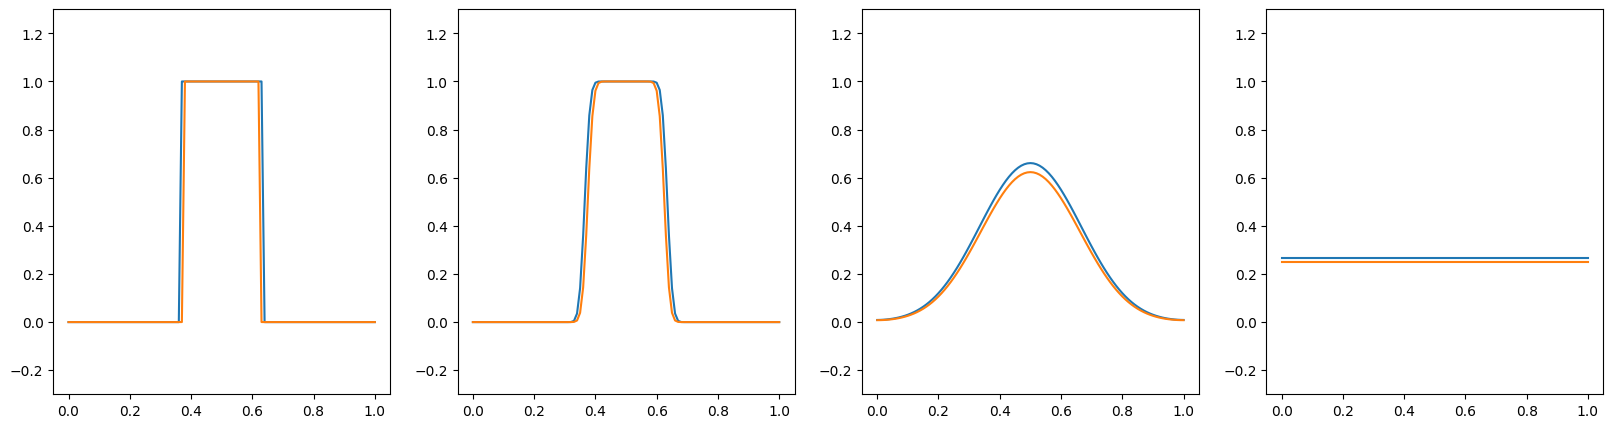

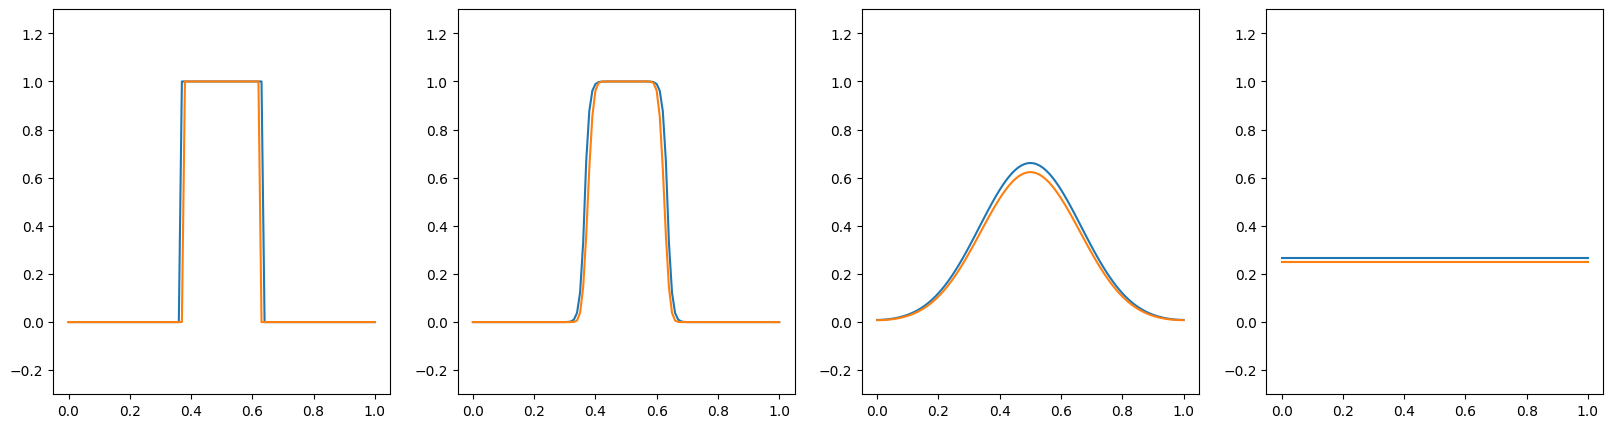

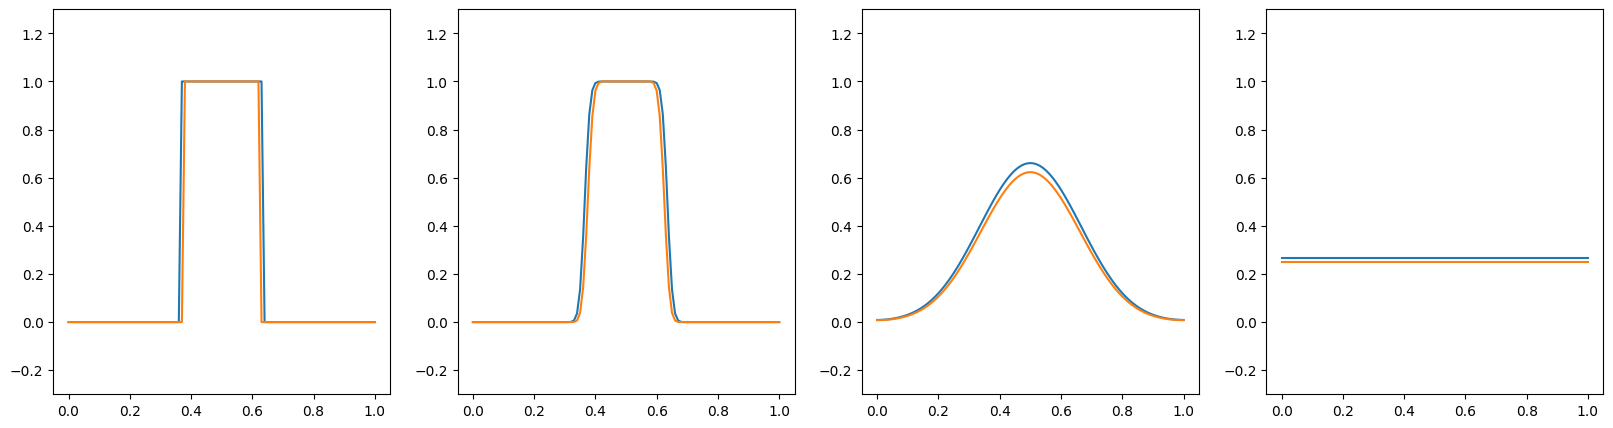

In [178]:
comparateur.set(N = 100, M = 50000, J = 10 ** 4)
print('(', comparateur.compare(), ', ', comparateur.compare(methode = 'imp'), ', ', comparateur.compare(methode = 'theta'), ')')

### b) Résultats de la méthode compare()
On donnera les résultats sous la forme d'un tuple (explicite, implicite, theta-schéma).

#### - valT $\in \{10^{-6}, 10^{-4}, 10^{-2}, 1\}$, theta = 0.2, p = 2
- N = 100, M = $10^3$: ( 20004.314 ,  5.508 ,  21.481 ) On observe très clairement que les schémas explicite et théta divergent alors que le schéma implicite est relativement proche de la solution analytique.
- N = 100, M = $10^5$: ( 2.458 ,  2.466 ,  2.460 ) Les courbes sont toutes assez proches de la solution analytique.

